# 基本配置

In [73]:
import utils
import numpy as np

import cnn
import time
import ssptm

# 数据集
dataset_dict = {
    # (%, dim): (0.999, 69) (0.99, 25) (0.95, 5)
    'Indian_Pines': {
        'shape': [145, 145],
        'dim': 200,
        'num_class': 16 + 1,
        'data_path': './datasets/IndianPines/Indian_pines_corrected.mat',
        'data_name': 'indian_pines_corrected',
        'label_path': './datasets/IndianPines/Indian_pines_gt.mat',
        'label_name': 'indian_pines_gt',
        'T': 162
    },
    # (%, dim): (0.999, 16) (0.99, 4) (0.95, 3)
    'Pavia_University': {
        'shape': [610, 340],
        'dim': 103,
        'num_class': 9 + 1,
        'data_path': './datasets/PaviaUniversity/PaviaU.mat',
        'data_name': 'paviaU',
        'label_path': './datasets/PaviaUniversity/PaviaU_gt.mat',
        'label_name': 'paviaU_gt',
        'T': 132
    },
    # (%, dim): (0.999, 6) (0.99, 3) (0.95, 2)
    'Salinas_Scene': {
        'shape': [512, 217],
        'dim': 204,
        'num_class': 16 + 1,
        'data_path': './datasets/SalinasScene/Salinas_corrected.mat',
        'data_name': 'salinas_corrected',
        'label_path': './datasets/SalinasScene/Salinas_gt.mat',
        'label_name': 'salinas_gt',
        # 'T': 102
        'T': 51

    },
}

In [74]:
# 噪声水平
noise_ratio = 0.3

# 扩散学习相关参数
pca_dim = 16  # PCA降维维度
dirty_ratio = 0.3  # unlabelled数据所占比例
alpha = 0.75  # 扩散程度

# cnn训练参数
batch_size = 4096

epoch_test = 50
lr_test = 0.0001

epochs_1 = 10
lr_1 = 0.0001

epochs_2 = 15
lr_2 = 0.0001

# 加载数据集并预处理

In [84]:
test_dataset = 'Salinas_Scene'
print("\n> 加载数据集并预处理...")
dataset = dataset_dict[test_dataset]
data, label = utils.load_dataset(dataset['data_path'], dataset['data_name'], dataset['label_path'],
                                 dataset['label_name'])

# 预处理
processed_data, one_hot_label, superpixels = utils.preprocess(data, label, dataset['num_class'], pca_dim,
                                                              dataset['T'])

# 提取出样本块
extracted_data, one_hot_label, superpixels = utils.extract_samples(processed_data, one_hot_label, superpixels,
                                                                   window_size=9, dataset_size=0.05)


> 加载数据集并预处理...


# 测试模型本身在数据集上的性能

In [85]:
# 测试模型本身在正确数据集上的性能：
# print("\n> 测试模型本身在正确数据集上的性能...")
# cnn._test(extracted_data, one_hot_label, pca_dim, dataset['num_class'],
#           test_size=0.3, epochs=epoch_test,
#           lr=lr_test, batch_size=batch_size, save_model=False)

# 生成带有噪声的数据集并划分


> 构造带有噪声的数据集[ratio=0.3]...


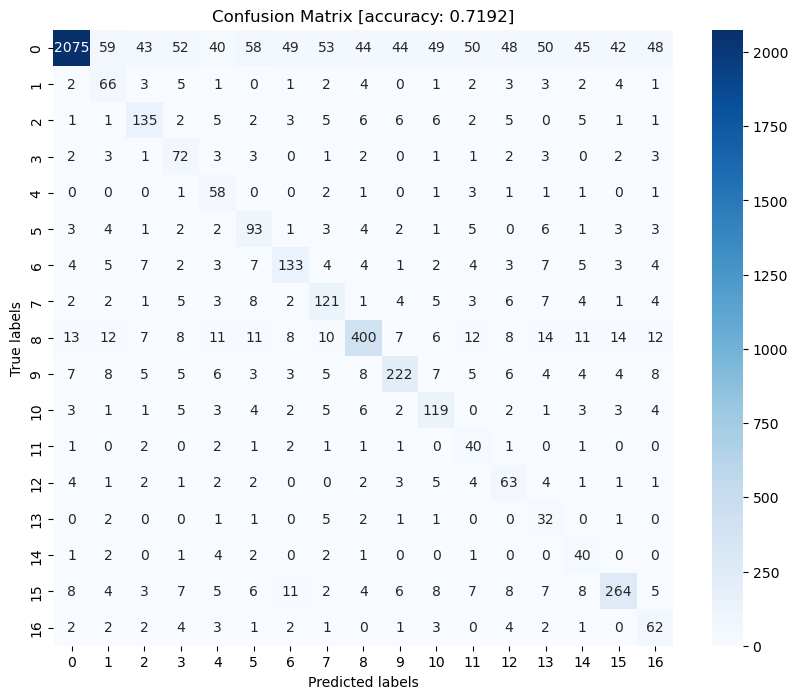

> The accuracy of labels with noise: 
------------------------------
Accuracy: 0.7191719171917191
Average Accuracy: 0.7133047747256848
Kappa: 0.6392480984218509
------------------------------


In [86]:
print(f"\n> 构造带有噪声的数据集[ratio={noise_ratio}]...")
# 向标签中增加噪声
noisy_label = utils.add_noise_to_label(one_hot_label, noise_ratio)

# 查看当前标签的正确率
evaluation_list = utils.evaluate(one_hot_label, noisy_label, noise_ratio=noise_ratio, save=False)
utils.print_evaluation(evaluation_list, '> The accuracy of labels with noise: ')

# 划分数据集(带有脏标签)
clean_data, dirty_data, clean_label, dirty_label, mask = utils.split_dataset(extracted_data, noisy_label,
                                                                             dirty_ratio)

# 初始化训练模型

In [87]:
# 训练模型
print("\n> 模型初始化训练中...")
model = cnn.train(clean_data, clean_label, pca_dim, dataset['num_class'], batch_size=batch_size, epochs=epochs_1,
                  lr=lr_1, save_model=False)


> 模型初始化训练中...
Epoch [1/10], Train Loss: 2.7070
Epoch [2/10], Train Loss: 2.0275
Epoch [3/10], Train Loss: 1.7858
Epoch [4/10], Train Loss: 1.6870
Epoch [5/10], Train Loss: 1.6084
Epoch [6/10], Train Loss: 1.5387
Epoch [7/10], Train Loss: 1.4781
Epoch [8/10], Train Loss: 1.4183
Epoch [9/10], Train Loss: 1.3625
Epoch [10/10], Train Loss: 1.3091


# 提取特征

In [88]:
# 提取特征
print("\n> 提取特征中...")
# 可以采用直接加载模型的方式，注释掉上述的训练模型部分
# model = './models/cnn_last.pth'
model, feature_data = cnn.feature_extract(model, extracted_data, pca_dim, dataset['num_class'])


> 提取特征中...


# 标签传播 - 构建SSPTM

In [154]:
from tqdm import tqdm
from joblib import Parallel, delayed


def sparse_affinity_matrix(data, superpixel, sim_type='gauss'):
    """
    根据超像素来构造表示不同样本间相似度的稀疏亲和矩阵A
    :param data: 样本
    :param superpixel: 超像素
    :param sim_type: 相似度度量 dot:向量点积
    :return: 稀疏亲和矩阵 A
    """
    num_samples, _ = data.shape
    # 将数组数值归一化至0~1
    normalized_data = (data - np.min(data)) / (np.max(data) - np.min(data))
    # print3d(normalized_data, id='normalized_data', superpixel=superpixel)

    # 初始化稀疏亲和矩阵 A
    A = np.zeros((num_samples, num_samples))

    # # 计算相似度矩阵
    # for i in range(num_samples):
    #     for j in range(num_samples):
    #         
    #         euclidean_distance_squared = np.sum(np.square(A[i] - A[j]))
    #         if euclidean_distance_squared > 0.5:
    #             A[i][j] = euclidean_distance_squared

    # 计算相似度矩阵的上三角部分
    def compute_euclidean_distance_squared(i, j):
        return np.sum(np.square(A[i] - A[j]))
    
    # 分块计算并行化
    block_size = 100
    num_blocks = num_samples // block_size
    for block_i in tqdm(range(num_blocks)):
        for block_j in range(block_i, num_blocks):  # 只计算上三角部分
            start_i, end_i = block_i * block_size, (block_i + 1) * block_size
            start_j, end_j = block_j * block_size, (block_j + 1) * block_size
            sub_A = A[start_i:end_i, start_j:end_j]
    
            # 使用CPU所有核心
            distances = Parallel(n_jobs=-1)(
                delayed(compute_euclidean_distance_squared)(i, j) 
                for i in range(start_i, end_i) for j in range(start_j, end_j)
            )
            distances = np.array(distances).reshape((block_size, block_size))
            sub_A[distances > 0.5] = distances[distances > 0.5]
    
    # 填充相似度矩阵的下三角部分
    A = np.maximum(A, A.T)


    return A

In [155]:
def generate_SSPTM(A):
    """
    生成SSPTM
    :param A: 亲和矩阵
    :return: SSPTM
    """
    # 将矩阵A与其转置相加，得到对称矩阵W
    W = A + A.T

    # 对W的每一行进行归一化，使其和为1
    normalized_W = W / np.sum(W, axis=1)[:, None]
    return normalized_W

In [156]:
import ssptm

# 标签传播过程
print("\n> 标签传播:")
# 构建SSPTM
print("构建SSPTM...")
A = sparse_affinity_matrix(feature_data, superpixels)
SSPTM = generate_SSPTM(A)
# 计算最大值
max_val = np.max(A)

# 计算最小值
min_val = np.min(A)

# 计算均值
mean_val = np.mean(A)

# 计算中位数
median_val = np.median(A)

print("最大值:", max_val)
print("最小值:", min_val)
print("均值:", mean_val)
print("中位数:", median_val)


> 标签传播:
构建SSPTM...


 27%|██▋       | 15/55 [10:26<27:50, 41.77s/it]


KeyboardInterrupt: 

# 预测伪标签并评价

预测伪标签...
Time taken[CG]: 4.051132917404175 seconds


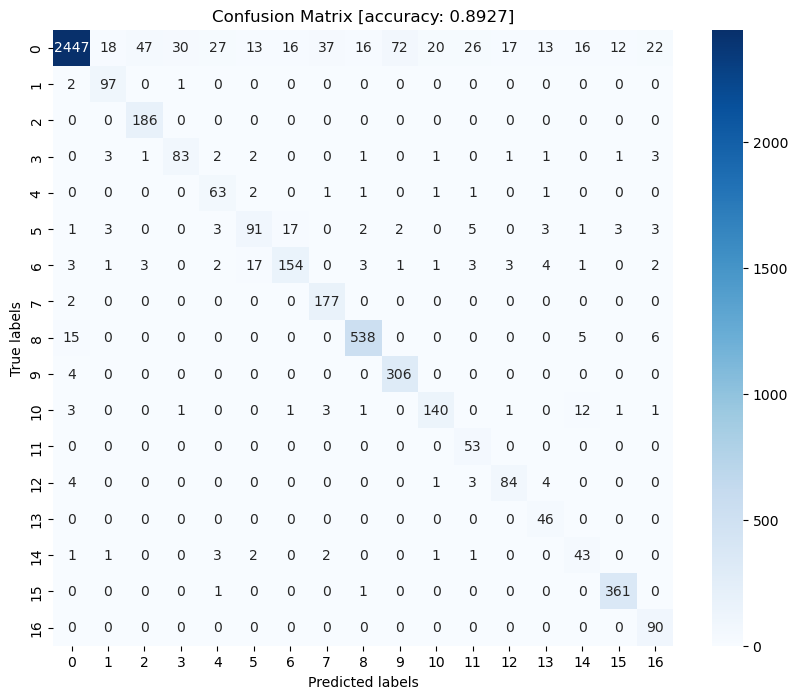

> 直接以伪标签作为结果:
------------------------------
Accuracy: 0.8927092709270927
Average Accuracy: 0.910201967219745
Kappa: 0.8559555065677951
------------------------------


In [92]:
# 预测伪标签
print("预测伪标签...")
remove_noise_label = utils.gen_label_for_propagation(noisy_label, mask)
pseudo_label, cg_solution, info = utils.diffusion_learning(SSPTM, remove_noise_label, alpha=alpha, verbose=False)

evaluation_list = utils.evaluate(one_hot_label, pseudo_label, noise_ratio=noise_ratio, save=False)
utils.print_evaluation(evaluation_list, '> 直接以伪标签作为结果:')

# 模型二阶段训练


> 模型第二阶段训练...
Epoch [1/15], Train Loss: 0.9437
Epoch [2/15], Train Loss: 0.8110
Epoch [3/15], Train Loss: 0.6368
Epoch [4/15], Train Loss: 0.5269
Epoch [5/15], Train Loss: 0.4791
Epoch [6/15], Train Loss: 0.4111
Epoch [7/15], Train Loss: 0.3569
Epoch [8/15], Train Loss: 0.3351
Epoch [9/15], Train Loss: 0.2947
Epoch [10/15], Train Loss: 0.2760
Epoch [11/15], Train Loss: 0.2496
Epoch [12/15], Train Loss: 0.2148
Epoch [13/15], Train Loss: 0.1969
Epoch [14/15], Train Loss: 0.1743
Epoch [15/15], Train Loss: 0.1596


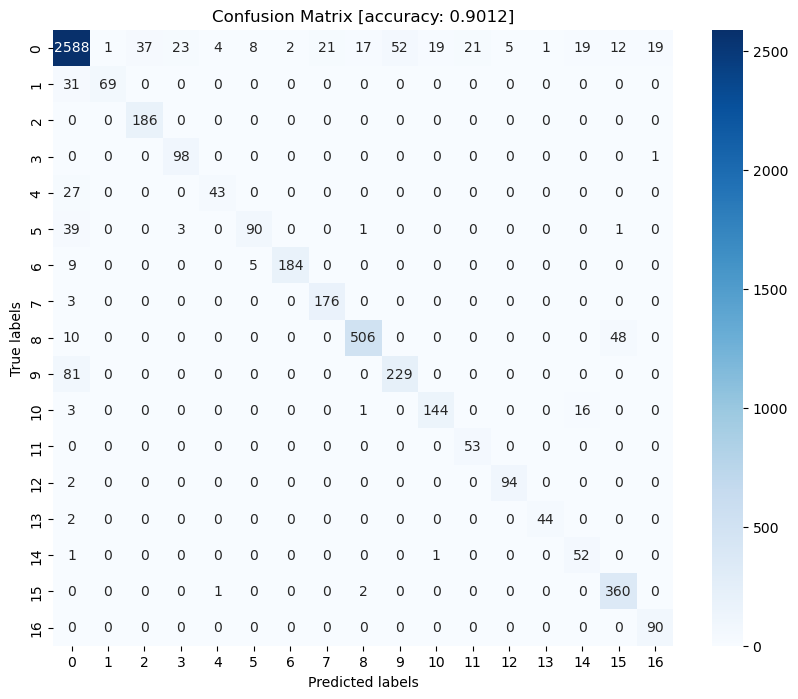

> 二阶段模型在整个数据集上的评价结果:
------------------------------
Accuracy: 0.9011701170117011
Average Accuracy: 0.8935915906352757
Kappa: 0.8623042114337494
------------------------------


In [93]:
print("\n> 模型第二阶段训练...")
model = cnn.train_2(model, extracted_data, pseudo_label, epochs=epochs_2, lr=lr_2, batch_size=batch_size,
                    save_model=False)
# 可以直接加载训练两次后的模型来进行预测，需要只是掉提取样本块后的代码
# model = cnn.load_model_eval(model_path, pca_dim, dataset['num_class'])
result_label = cnn.cls(model, extracted_data, batch_size=batch_size)
evaluation_list = utils.evaluate(one_hot_label, result_label, noise_ratio=noise_ratio, save=False)
utils.print_evaluation(evaluation_list, '> 二阶段模型在整个数据集上的评价结果:')